# Machine Learning Approaches to Housing Price Prediction

Name: Jaime Pantoja | 
Student #: 243604 | 
Date: June 17, 2024

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import the data

In [2]:
# Donwload the data from 'https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data' and load it as a dataframe
data = pd.read_csv('data/train.csv')
print(data.shape)

(1460, 81)


# Handling Missing Values

In [3]:
# The Id feature from the datast because it is not relevant for the analysis
data = data.drop('Id', axis= 1)
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Find if there is any missing values in the dataset 
missing_data = pd.DataFrame(data.isna().sum())
filtered_data = missing_data.loc[missing_data.sum(axis=1)> 0]
print(filtered_data)
print("_______________________________________")
print(f'The total number of na values is: {data.isna().sum().sum()} ')


                 0
LotFrontage    259
Alley         1369
MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
FireplaceQu    690
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
PoolQC        1453
Fence         1179
MiscFeature   1406
_______________________________________
The total number of na values is: 6965 


There are various approaches for dealing with missing values. Some of these approaches include deletion, imputation, or specialized methods (Joel, Doorsamy and Paul, 2022). Before choosing an approach, it’s crucial to identify the type of missing data within the columns. This information is relevant because it guides the appropriate strategy to handle missing values effectively.

In [5]:
# Get the columns' names with missing values (List)
columns_with_missing = data.columns[data.isnull().any()].tolist()

# Get the datatype of those columns to identify which ones ate float64 or object
dtypes_missing = data[columns_with_missing].dtypes

print(dtypes_missing)

LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence            object
MiscFeature      object
dtype: object


One strategy for managing missing values in columns with object data types involves using the fillna method, which replaces the missing values with a specified string.

In [6]:
# Get the column names for the columns with missing values from type object
object_columns = data[columns_with_missing].select_dtypes(include='object').columns.tolist()

# Use fillna to handle missing values
data[object_columns] = data[object_columns].fillna('UNKNOWN')

# Check the missing values again
columns_with_missing_2 = data.columns[data.isnull().any()].tolist()
dtypes_missing_2 = data[columns_with_missing_2].dtypes
print(dtypes_missing_2)

LotFrontage    float64
MasVnrArea     float64
GarageYrBlt    float64
dtype: object


Now, the columns with missing values are of type float64, and they need to be handled differently. Depending on the variable type (categorical or continuous), we can choose between filling with the most frequent value or the average. The data handling process will proceed as follows:

* 'GarageYrBlt' (categorical) Fill missing values with the most frequent value in the ‘GarageYrBlt’ column.

* 'LotFrontage' (Continuous) Impute missing values by using the average and rounding to the nearest integer.

* 'MasVnrArea' (Continuous) Replace missing values with zero for the ‘MasVnrArea’ column.

In [7]:
# GarageYrBlt
data['GarageYrBlt'].fillna(data['GarageYrBlt'].mode()[0], inplace=True)

# LotFrontage
data['LotFrontage'].fillna(data['LotFrontage'].mean().round().astype(int), inplace=True)

# MasVnrArea
data['MasVnrArea'].fillna(0, inplace=True)

columns_with_missing_3 = data.columns[data.isnull().any()].tolist()
dtypes_missing_3 = data[columns_with_missing_3].dtypes
print(dtypes_missing_3)

Series([], dtype: object)


# Data analysis - Features Selection

The data frame contains 79 features, making it essential to filter out the most relevant ones. The primary objective of reducing the number of variables is to decrease model complexity and avoid the "curse of dimensionality," which can lead to increased computational complexity and poor generalization.

One effective method for feature selection is correlation analysis, as it helps identify relationships among features. This approach aids in removing redundant variables and selecting only the most relevant ones.

C:\Users\jaime\AppData\Local\Temp\ipykernel_30144\3864085256.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


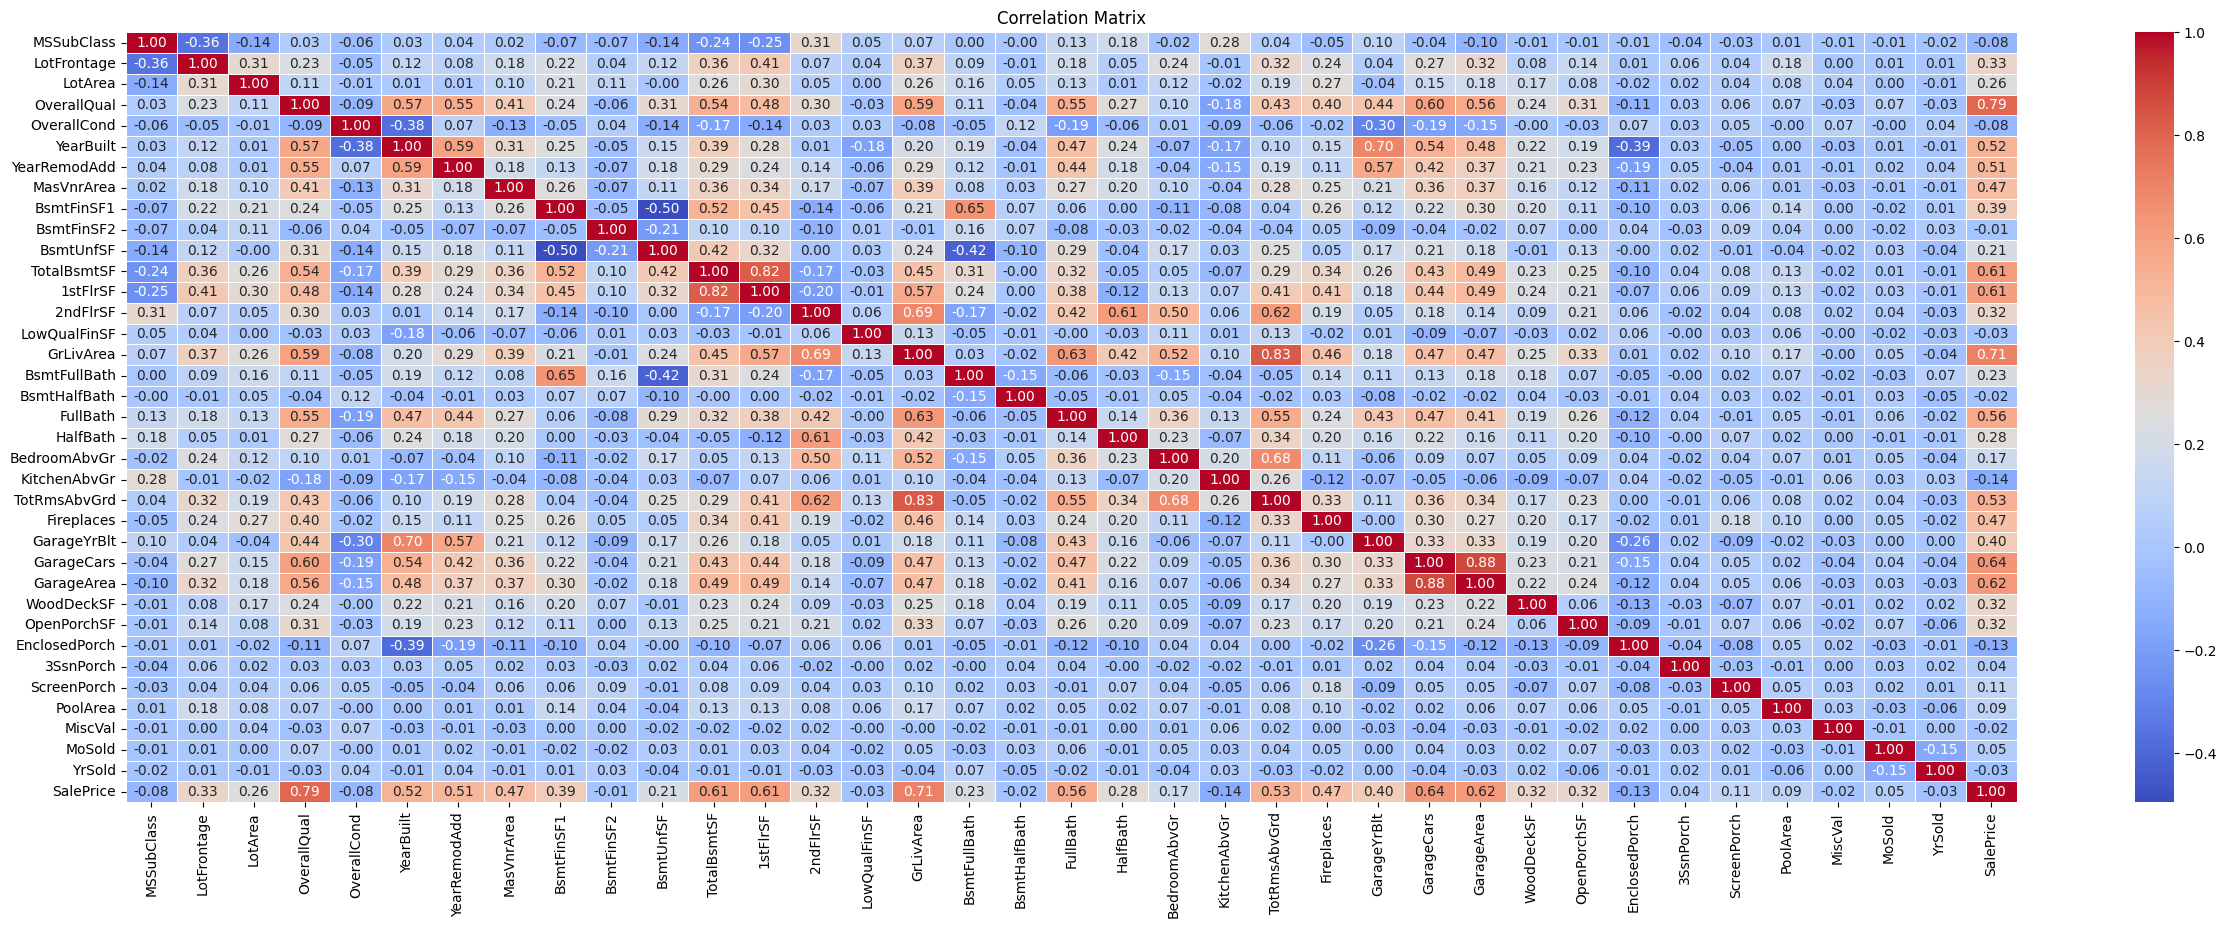

In [8]:
# Get the correlation from the dataset. Considers only the numerical values
correlation_matrix = data.corr()

# Create a heatmap plot
plt.figure(figsize=(30.5, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

Observations from the Correlation Table

1. <u>Strong Positive Correlations:</u> The following numerical features exhibit the highest positive correlations with the target value (Sale Price), as indicated by the correlation coefficients in parentheses:

    * ‘OverallQual’ (0.79)
    * ‘GrLivArea’ (0.71)
    * ‘GarageCars’ (0.64) and ‘GarageArea’ (0.62)
    * ‘TotalBsmtSF’ (0.61) and ‘1stFlrSF’ (0.61)
    * ‘YearBuilt’ (0.52) and ‘YearRemodAdd’ (0.51)
    * ‘FullBath’ (0.56)
    * ‘Fireplaces’ (0.47)

2. <u>Weak Correlations:</u> Features with correlations close to zero have little influence on the Sale Price. Examples include ‘OverallCond’, ‘BsmntFinSF2’, ‘LowQualFinSF’, and ‘BsmntHalfBath’.

3. <u>Strong Variable Relationships:</u> Notably, some variables in the dataset exhibit strong correlations with each other that need to be handled to avoid multicollinearity in the model.

    * ‘GarageCars’ and ‘GarageArea’
    * ‘YearBuilt’ and ‘YearRemodAdd’ and ‘GarageYrBlt’
    * ‘TotalBsmtSF’ and ‘1stFlrSF’
    * ‘TotRmsAbvGrd’ and ‘GrLivArea’

* Based on the analysis, we can refine the numerical features by selecting those with the highest correlation to the target variable. For pairs of variables that are highly correlated with each other, such as GarageCars and GarageArea, only one should be retained to avoid redundancy. This approach ensures that the model remains efficient and avoids the pitfalls of overfitting. Consequently, the model will be trained using only the following selected features:

    * ‘OverallQual’
    * ‘GrLivArea’
    * ‘GarageCars’
    * ‘TotalBsmtSF’
    * ‘YearBuilt’
    * ‘FullBath’
    * ‘Fireplaces’


The dataframe contains non numeric features that need to be filtered as well. We can visualize the names of the columns in the next code output

In [9]:
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


For the non-numerical features, some can be omitted because they indicate similar conditions of the data points.

* Street, Alley, and PavedDrive point to similar categories. <u>Street</u> so street can be maintained
* LotShape and LandContour characterize the physical space of the property. Keep <u>LotShape</u>
* Condition 1 and 2. Keep <u>Condition 1</u>
* HouseStyle and BldgType both indicate the type of dwelling. Keep <u>HouseStyle</u>
* RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond indicate exterior conditions. The feature that gives the most complete condition is the <u>ExterCond</u> indicating the overall exterior condition
* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2. Basement condition (<u>BsmtCond</u>) can summarize the other four variables.
* Heating, HeatingQC, CentralAir. <u>HeatingQC</u> defines the overall condition of the heating.
* <u>KitchenQual</u>
* GarageType, GarageType, GarageQual, GarageCond. Keep <u>GarageQual</u> indicates the overall garage quality.


In [10]:
selected_numerical_features = [ 'SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
selected_non_numerical_features = [ 'Condition1']
selected_features = selected_numerical_features + selected_non_numerical_features

# Handling Outliers 

One approach for handling outliers is to visualize the data. The graphs  help to find points that are distant from the rest of the distribution. Graphs like box plots and histogram are useful for this purpose.

This graphs can be plotted for all the numercal values

In [11]:
# Get a dataFrame with only the numerical values
data_numeric = data.select_dtypes(include=['float64', 'int64'])

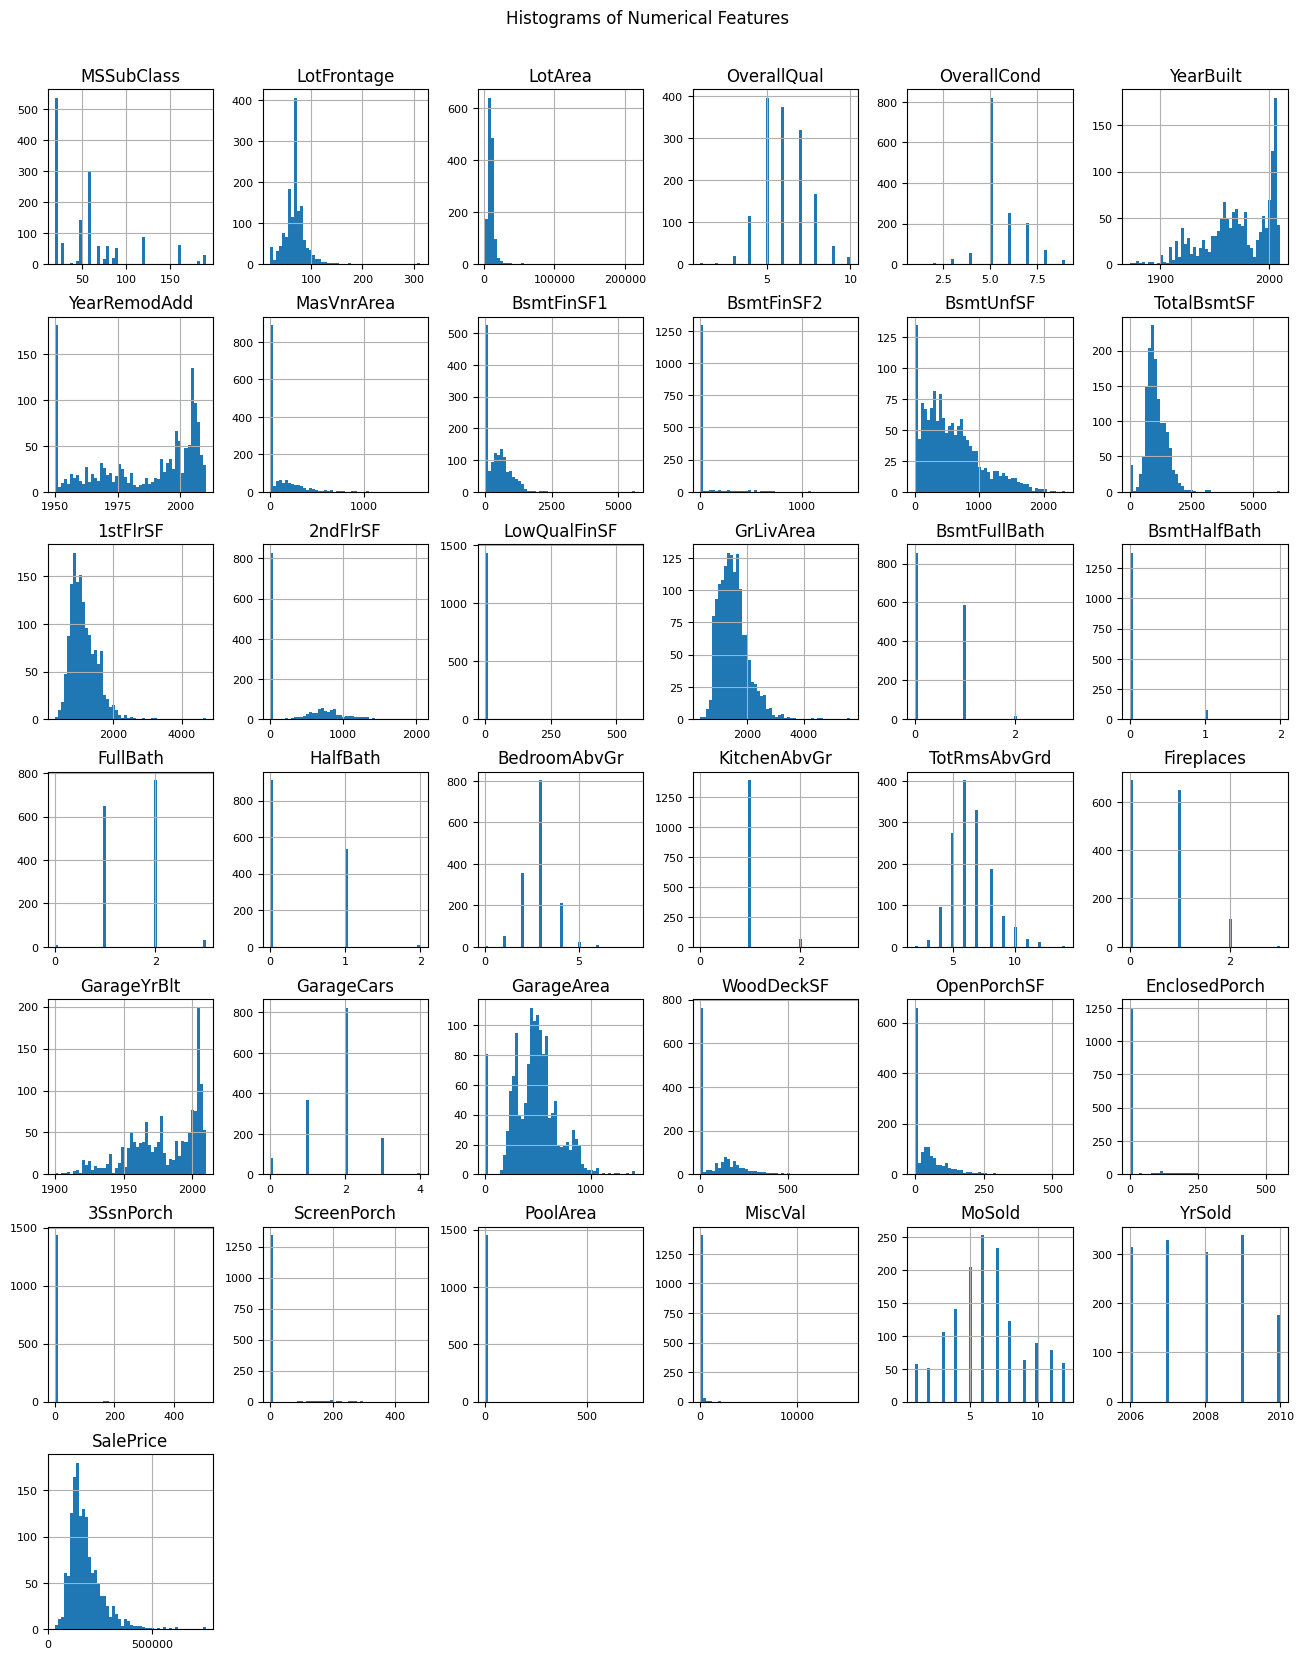

In [12]:
## -- Get the distribution of all the numeric features --##

# Create histograms for numerical features
data_numeric.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

# Customize plot labels and titles
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.suptitle('Histograms of Numerical Features', y=0.92)

plt.show()

From this collection of graphs, we can identify the features of interest where outlier-handling methods can be applied. Specifically, this report will focus on the following features: 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath', 'Fireplaces'.

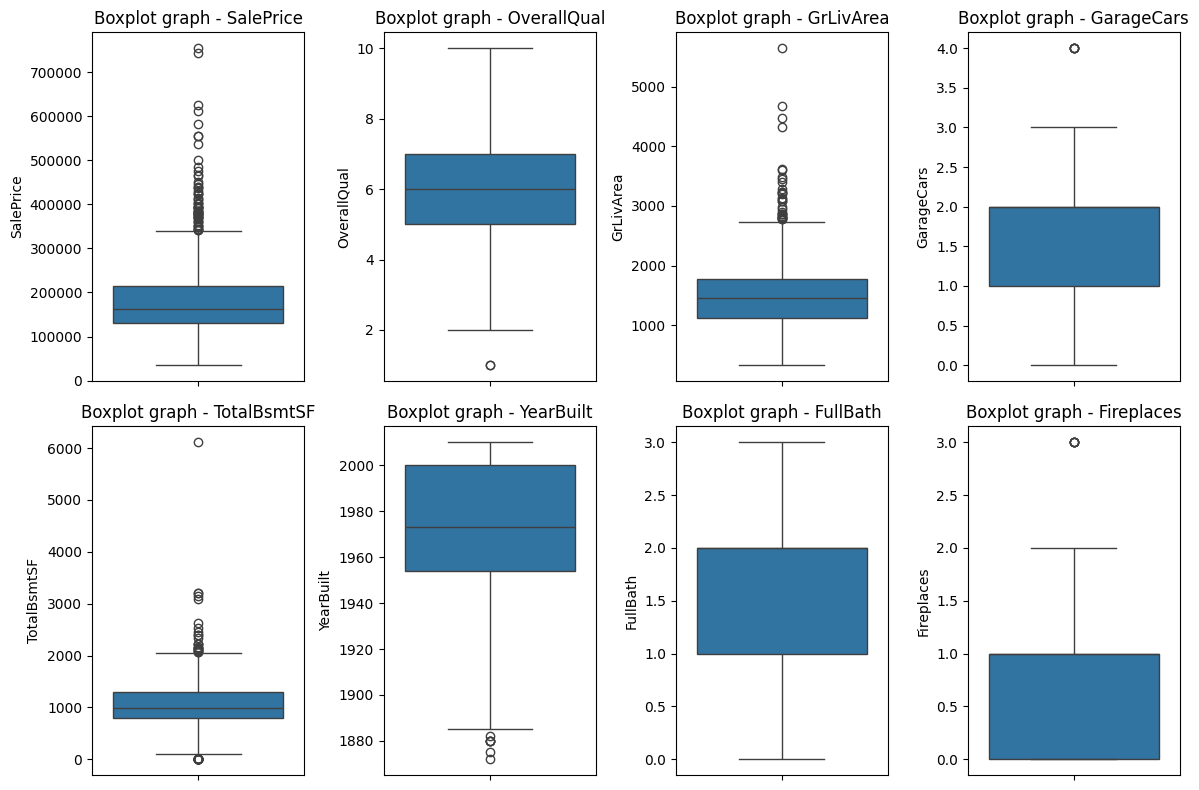

In [13]:
# Define variables for boxplots
columns = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath', 'Fireplaces']


# Create a figure and axes for the subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

# Iterate over the variables and plot the boxplots
for i, column in enumerate(columns):
    sns.boxplot(data[column], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f"Boxplot graph - {column}")
    axes[i//4, i%4].grid(False)

# Adjust the layout
plt.tight_layout()
plt.show()

As observed in the box plots above, the feature distributions exhibit outliers that can be addressed using various mechanisms. For this report, we will utilize the Interquartile Range (IQR) method, which identifies any data point above 1.5 times the IQR beyond the third quartile or below the first quartile as an outlier (Foxwell, 2020).

In [14]:
# The function removes the outliers from a specified column within the DataFrame
def remove_outliers(df, column, m=1.5):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - m * IQR
    upper_bound = Q3 + m * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

columns_outliers = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearBuilt', 'FullBath', 'Fireplaces']

# Iterate through the list with the column names using the remove_outliers function
for col in columns_outliers:
    data = remove_outliers(data, col)

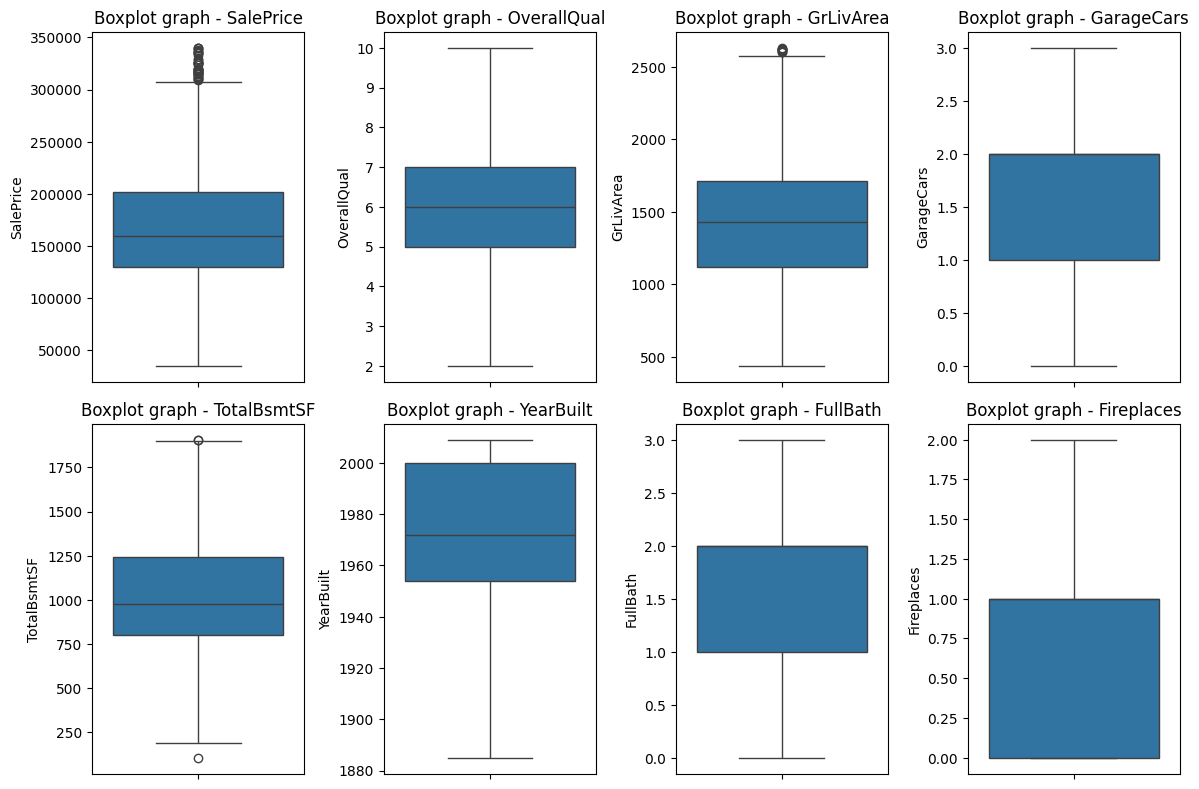

In [15]:
# Create a figure and axes for the subplots
fig_2, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))

# Iterate over the variables and plot the boxplots
for i, column in enumerate(columns):
    sns.boxplot(data[column], ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f"Boxplot graph - {column}")
    axes[i//4, i%4].grid(False)

# Adjust the layout
plt.tight_layout()
plt.show()

# Encoding Categorical Variables

Categorical variables need to be transformed into numbers so they can be passed into the models for training (Galli, 2022). There are different ways to achieve the transformation, the two most frequently use are One-Hot Encoding or Label Encoding. This report will consider  Label encoding for processing the categorical variables.

But before encoding the variables the dataset should be filtered with the selected_features list defined before.

In [16]:
data_filtered = data[selected_features].copy()

In [17]:
# Apply label encoding to categorical variables. Use dtype object as a reference
for column in data_filtered.select_dtypes(include='object'):
    data_filtered[column] = LabelEncoder().fit_transform(data[column])

data_filtered.head(3)

,SalePrice,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,Condition1
0,208500,7,1710,2,856,2
1,181500,6,1262,2,1262,1
2,223500,7,1786,2,920,2


In [18]:
# Divide the data into x and y so later on is possible to create the training and testing datasets.
x = data_filtered.drop('SalePrice', axis=1)
y = data_filtered['SalePrice']

columns_x = x.columns.values.tolist()

print(columns_x)

['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'Condition1']


# Normalization

Normalization ensures that all features (independent variables) are on the same scale. Various methods exist for normalizing data. In this report, normalization is implemented using  Min-Max Scaling approach

In [19]:
scaler = MinMaxScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

scaler_y = MinMaxScaler()
y_normalized = pd.DataFrame(scaler_y.fit_transform(y.values.reshape(-1, 1)), columns=['SalePrice']) 
y_normalized.head()

,SalePrice
0,0.568994
1,0.480498
2,0.618158
3,0.344477
4,0.705015


# Split the training dataset

In [20]:
X_train, X_val, y_train, y_val = train_test_split(data_normalized, y_normalized, test_size=0.2, random_state=42)
X_train.shape

(1052, 5)

# Regression Models

The training phase will involve deploying multiple models to compare their results and identify which one provides the best predictions. Initially, two Deep Neural Network (DNN) models will be defined using a specific set of hyperparameters and architectures. Subsequently, various regression techniques will be implemented using libraries that offer pre-built templates.

The objective is to evaluate the performance of these models and determine which one generalizes the data most effectively for accurate predictions.




## Support Functions

### Validation Loss Curves

Develop a function to visualize validation loss curves. This essential tool facilitates performance monitoring, aids in detecting overfitting or underfitting, and assists in fine-tuning neural network architecture and hyperparameters. 

In [21]:
# Function to plot training and validation loss
def plot_loss(history, name_Model):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss | {name_Model}')
    plt.legend()
    plt.show()

### Mean Squared Error function 

This functions returns the Mean Squared Error (MSE) of a model based on the the input data, in this case, the X_val and y_val defined before in the notebook.

In [22]:
# Function to print the Mean Squared Error
def mse_function (model):

    # X_val and y_val are defined before in the notebook

    y_pred_test = model.predict(X_val)
    mse_test = mean_squared_error(y_val, y_pred_test)

    return round(mse_test, 4)
   

## Deep Neural Networks (DNN) Models.

Deep Neural Networks (DNNs) are commonly used for pricing regressions due to their ability to learn complex patterns, identify relationships, and manage the non-linearity inherent in various real-world scenarios. The network results will depend on the architecture and hyperparameters. In this stage, two Deep Neural Networks architectures will be implemented. 

The first model will follow the architecture based on the research paper 'Real-estate price prediction with deep neural network and principal component analysis' by Mostofi, Toğan, and Başağa (2022). The second one will use a different architecture with a dropout regularization technique to avoid overfitting.

## DNN-Model-1

This model will consider the research papaer from Mostofi, Toğan, and Başağa the main points consider for are: 

* Adam as the optimization function
* Relu as the regression activation function
* Best performance using 20 - 30 neurons. The model will use 30 neurons
* The best training when the model has between 5-10 layers. In this case, the model will consider 6 layers


In [23]:
# Define the model
model_1_DNN = Sequential()
model_1_DNN.add(Dense(30, input_dim=5, activation='relu'))# Input 
for _ in range(5):  # Adding 5 hidden layers
    model_1_DNN.add(Dense(30, activation='relu'))# Hidden layers
model_1_DNN.add(Dense(1))  # Output layers - single output for regression

# Compile the model
model_1_DNN.compile(optimizer=Adam(), loss='mean_squared_error')

c:\Users\jaime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
# Plot the structure of the DNN
model_1_DNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,861 (18.99 KB)

 Trainable params: 4,861 (18.99 KB)

 Non-trainable params: 0 (0.00 B)

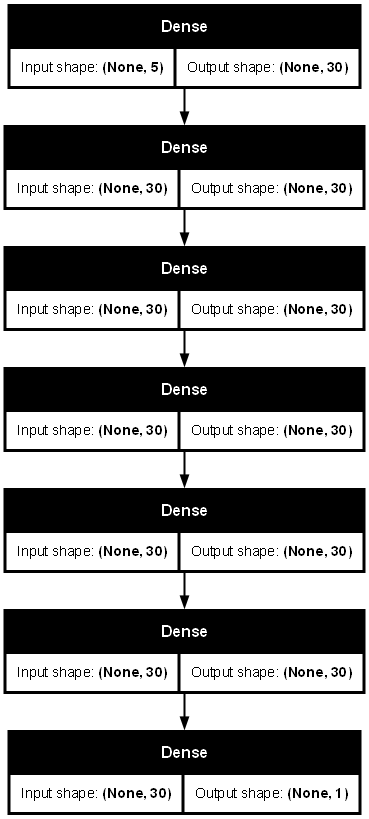

In [39]:
# Plot the model
plot_model(model_1_DNN, to_file='model-1-DNN.png', show_shapes=True, dpi=72)

In [26]:
# Training the model
DNN_1 = model_1_DNN.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=300)

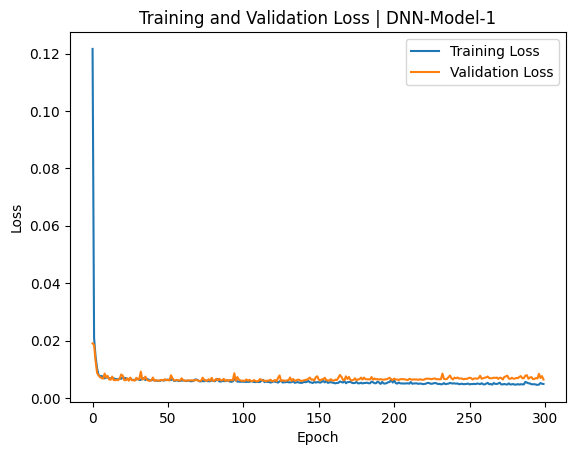

In [27]:
# Plot the Loss Curve
plot_loss(DNN_1, 'DNN-Model-1')

In [28]:
# Testing the model with the validation data
mse_DNN_1 = mse_function(model_1_DNN)
print(f'Test MSE: {mse_DNN_1}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test MSE: 0.0081


## DNN-Model-2 

Model 2 explores different architecture, cahnges the number of neurons and employs various techniques to imrpve the performance metric (MSE)

In [29]:
# Define the model
model_2_DNN = Sequential()
model_2_DNN.add(Dense(64, input_dim=5, activation='relu', kernel_regularizer=l2(0.01)))
model_2_DNN.add(Dropout(0.5))
model_2_DNN.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_2_DNN.add(Dropout(0.5))
model_2_DNN.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model_2_DNN.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_2_DNN.compile(optimizer=optimizer, loss='mean_squared_error')

c:\Users\jaime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Plot the structure of the DNN
model_2_DNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

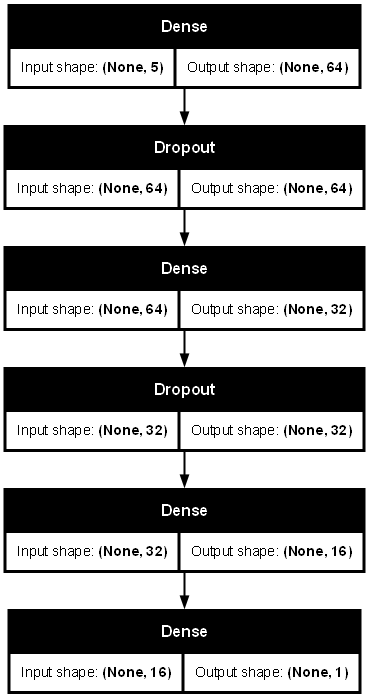

In [38]:
# Plot the model
plot_model(model_2_DNN, to_file='model-1-DNN.png', show_shapes=True, dpi=72)

In [32]:
# Training Model 2 
DNN_2 = model_2_DNN.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=300)

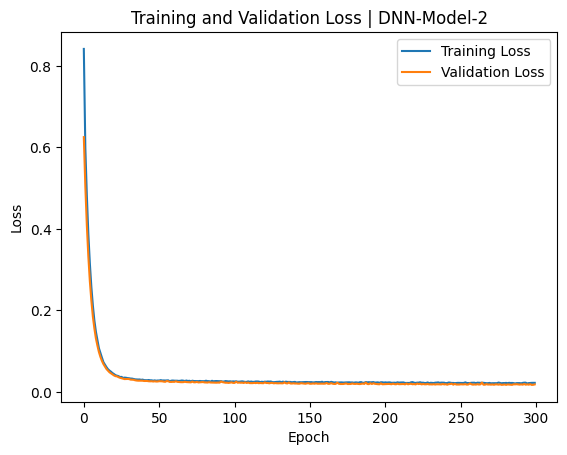

In [33]:
# Plot the Loss Curve
plot_loss(DNN_2, 'DNN-Model-2')

In [34]:
# Testing the model with the validation data
mse_DNN_2 = mse_function(model_2_DNN)
print(f'Test MSE: {mse_DNN_2}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Test MSE: 0.0112


## Other Regression Models (Linear and Decision Tree)

In the context of regression models, Python's Scikit-Learn library stands out as a powerful tool, offering simple yet effective resources for implementing machine learning algorithms. Scikit-Learn includes a set of pre-built regression models, which can serve as benchmarks for comparison with custom-developed models. The lines of code below implement a linear regression and a decision tree regressor.

In [35]:
# List of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
}

# Dictionary to store the MSE results
mse_results = {}
feature_importance = None

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_val)  # Predict on validation set
    mse = mean_squared_error(y_val, y_pred)  # Calculate MSE
    mse_results[name] = round(mse, 10)  # Store the MSE result

    if name == 'Decision Tree':
        feature_importance = model.feature_importances_


# Print the MSE results
for name, mse in mse_results.items():
    print(f'{name}: MSE = {mse}')

Linear Regression: MSE = 0.0076708212
Decision Tree: MSE = 0.0129211337


# Result Table

The following code snipet shows the  list of the models implemented and its MSE ordered in ascending order.

In [36]:
# Add the MSE for the two DNN models
mse_results['DNN - Model 1'] = mse_DNN_1
mse_results['DNN - Model 2'] = mse_DNN_2

# Sort the dictionary 
sorted_results = dict(sorted(mse_results.items(), key=lambda item: item[1]))

# Print Sorted dictionary
for model, mse in sorted_results.items():
    print(f'\033[1;4m{model}\033[0m [MSE]: {mse}')

Linear Regression [MSE]: 0.0076708212
DNN - Model 1 [MSE]: 0.0081
DNN - Model 2 [MSE]: 0.0112
Decision Tree [MSE]: 0.0129211337


## Features Importance

One of the key advantages of using a decision tree regressor is its interpretability. The decision tree model provides a feature importance attribute, which reveals the relative weight of each attribute in predicting the target variable. To gain insights into the model that performed best on the dataset, we can visualize these feature importances, thereby understanding which attributes are most influential in predicting the price.

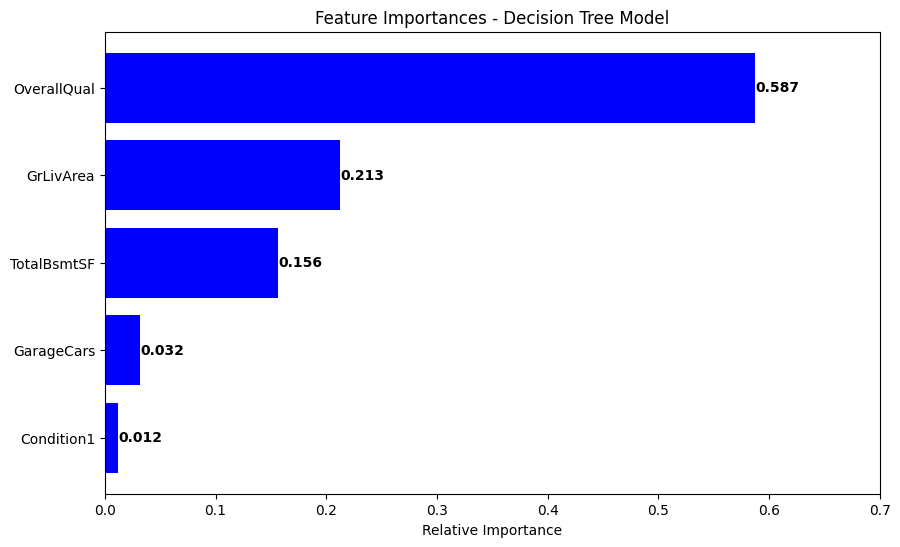

In [37]:

# The feature names are in the same order of X_train, in this way the score and the name of the column match

features_names = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'Condition1']
indices = np.argsort(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), [feature_importance[i] for i in indices], color='b', align='center')

# Add importance scores as labels
for i, v in enumerate(feature_importance[indices]):
    plt.text(v, i, f'{v:.3f}', va='center', color='black', fontweight='bold')
plt.yticks(range(len(indices)), [features_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Feature Importances - Decision Tree Model')
# Set the x-axis range
plt.xlim(0, 0.7)

plt.show()  # Display the plot

This results align with the correlation table defined before, where the 'OverallQual' had the highest correalation with the sale price. In terms of the importance score the OverallQual had the hishgest relative importance within the tree model with a score of 0.58. In other words, this variable had the greatest impact on the tree's decisions. In the same order of ideas, other variables such as 'GrLivArea', and 'TotalBsmtSF' have an importance score of 0.20 and 0.16 respectively.

In conclusion the feature importance attribute indicates that three attributes ('OverallQual', 'GrLivArea', 'TotalBsmtSF')  contribute the most to the relative importance within the tree model.

# Conclusion

The linear regression model achieved the lowest MSE at 0.0077, highlighting its simplicity and effectiveness. DNN-Model-1 followed closely with an MSE of 0.0084, demonstrating the potential of neural networks. However, DNN-Model-2 and the Decision Tree had higher MSEs at 0.0114 and 0.0123, respectively. 

These findings suggest that while linear regression provides a strong baseline due to its simplicity, there is potential for improvement in deep neural networks. By conducting further analysis and experimentation with different architectures and hyperparameters, the performance of neural networks can be enhanced.

# Bibliography

Fatemeh, M., Vedat, T. and Basri, B.H. (2022) 'Real-estate price prediction with deep neural network and principal component analysis', Organization, Technology and Management in Construction, 14(1), pp. 2741-2759. doi: 10.2478/otmcj-2022-0016.

Foxwell, H.J. (2020) Creating Good Data: A Guide to Dataset Structure and Data Representation. 1st edn.Apress.

Galli, S. (2022)  Python Feature Engineering Cookbook. 2nd edn.Packt Publishing.

Joel, L.O., Doorsamy, W. and Paul, B.S. (2022) 'A Review of Missing Data Handling Techniques for Machine Learning', International Journal of Innovative Technology and Interdisciplinary Sciences, 5(3), pp. 971–1005. doi: https://doi.org/10.15157/IJITIS.2022.5.3.971-1005.



